In [2]:
# Final word embedding technique
import re
from string import punctuation

import nltk
import plotly.express as px
from gensim.models import KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from umap import UMAP

ImportError: Numba needs NumPy 1.21 or less

In [ ]:
!pip install wordcloud

In [1]:
model = KeyedVectors.load_word2vec_format(
    '/Users/prush/PycharmProjects/thesis/biomedvis/filter/static/mlmodels/BioWordVec_PubMed_MIMICIII_d200.txt',
    binary=True)
# model = KeyedVectors.load_word2vec_format(
#     '/Users/prush/PycharmProjects/thesis-test/visBioMed/filter/static/mlmodels/bio_embedding_intrinsic',
#     binary=True)

NameError: name 'KeyedVectors' is not defined

In [31]:
def preprocess_sentence_returns_list(text):
    stop_words = set(stopwords.words('english'))
    # stop_words.extend(['from', 'subject', 're', 'edu', 'use','figure', 'fig'])
    # stemmer = SnowballStemmer("english")
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    cleanr = re.compile('\[(.*?)\]')
    text = re.sub(cleanr, '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub("[0-9]{2}", '', text)
    text = text.replace('/', ' ')
    text = text.replace('\'', ' \' ')
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pat, '', text)
    text = text.lower()

    # Tokenise the text - try with bert tokeniser later
    words = word_tokenize(text)
    # words = text.split()
    # text = ' '.join([stemmer.stem(word) for word in words])
    # words = [stemmer.stem(word) for word in words]
    text = ' '.join([lem.lemmatize(word) for word in words])
    # text = ' '.join(words)
    text = ' '.join([w for w in text.split() if len(w) > 1])
    text = text.replace('/`/', '')
    text = text.replace('/"/', '')
    text = text.replace("/'/", "")

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]
    return tokens

In [52]:
def generate_word_embeddings():
    with open('../articles_data/all_articles_with_thumbnail_metadata.json') as f:
        papers = json.load(f)

    # To encode the papers, we must combine the title and the abstracts to a single string
    article_texts = [preprocess_sentence_returns_list(paper['article_title'] + ' ' + paper['abstract']) for paper in
                     papers]
    article_titles = [preprocess_sentence_returns_list(paper['article_title']) for paper in papers]
    return article_titles, article_texts



In [33]:
processed_titles, processed_content = generate_word_embeddings()
# List of list to list
flat_list = [item for sublist in processed_content for item in sublist]
len(flat_list)



27284

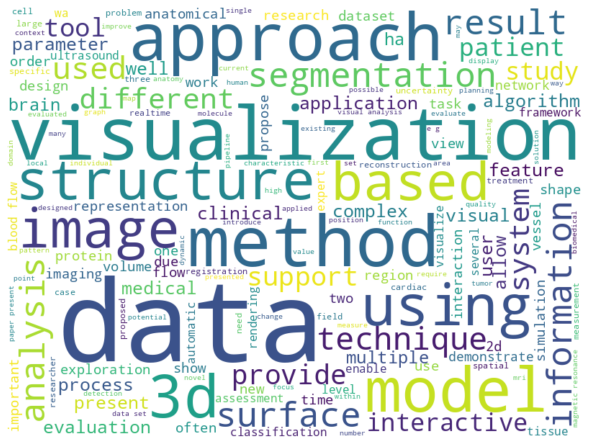

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = flat_list
text = " ".join(text)

wordcloud = WordCloud(width=800, height=600,
                      background_color='white',
                      min_font_size=10,
                      max_words=200).generate(text)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [35]:
from collections import Counter

count = Counter(flat_list)
tagged_words = nltk.pos_tag(flat_list)
words = [word for word, pos in tagged_words if
         (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos == 'CD')]

len(words)


14588

In [36]:
k = ['e.g', 'etc', 'i.e', '..']
unique_words = list(set(item for item in words if flat_list.count(item) >= 5 and item not in k))
len(unique_words)

775

In [90]:
import numpy as np
import plotly.io as pio

doc_vectors = []
word_vecs = [np.array(model[word]).tolist() for word in unique_words if word in model.key_to_index]
print(len(word_vecs))
model_words = [word for word in unique_words if word in model.key_to_index]
print(len(model_words))

umap_embeddings = UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
low_dim_embeddings = umap_embeddings.fit_transform(word_vecs)
print(low_dim_embeddings)
pio.renderers.default = "browser"
fig = px.scatter(low_dim_embeddings, x=0, y=1, opacity=1, text=model_words)

config = {
    'toImageButtonOptions': {
        'format': 'png',  # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 500,
        'width': 700,
        'scale': 1  # Multiply title/legend/axis/canvas sizes by this factor
    },
    'scrollZoom': True
}


def improve_text_position(x):
    """ it is more efficient if the x values are sorted """

    positions = ['top center', 'bottom center']  # you can add more: left center ...
    return [positions[i % len(positions)] for i in range(len(x))]


fig.update_traces(textposition=improve_text_position(low_dim_embeddings))
fig.update_layout(
    margin=dict(l=5, r=5, b=30),
    title_font_family="poppins",
    title_x=0.5,
    title_font_color="Grey",
    xaxis_title='',
    yaxis_title='',
    xaxis=dict(
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    yaxis=dict(  # attribures for y axis
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    hoverlabel=dict(
        bgcolor="#ffffff",
        font_size=12,
        font_color="#141414",
        font_family="Calibri",
        bordercolor="#204ab3",
    ),
    plot_bgcolor='white',
)
# fig.update_traces(textposition='top center')
fig.show(config=config)
fig.write_image("fig1.png")




772
772
[[10.396647  10.744835 ]
 [ 9.278151   7.7402563]
 [11.268246  10.286566 ]
 ...
 [ 4.9792256 10.26628  ]
 [11.212661   8.523099 ]
 [ 2.8111937  9.75148  ]]


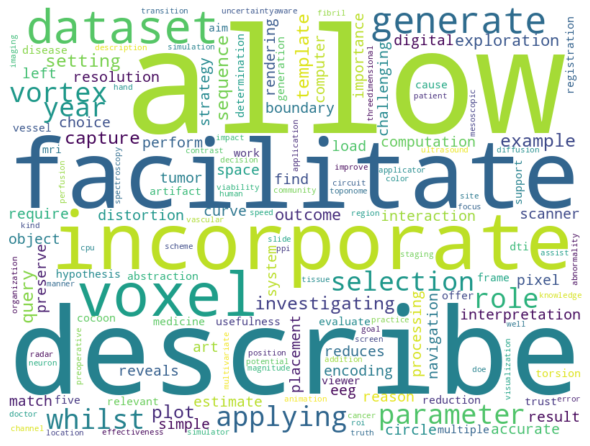

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = unique_words
text = " ".join(text)

wordcloud = WordCloud(width=800, height=600,
                      background_color='white',
                      min_font_size=10,
                      max_words=200).generate(text)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [124]:
# using spacy and scispacy

In [136]:

import spacy

nlp = spacy.load("en_core_sci_sm")


def extract_entities_from_text():
    with open('../articles_data/all_articles_with_thumbnail_metadata.json') as f:
        papers = json.load(f)

    # To encode the papers, we must combine the title and the abstracts to a single string
    article_texts = [nlp(paper['article_title'].lower() + ' ' + paper['abstract'].lower()) for paper in
                     papers]
    article_titles = [nlp(paper['article_title']) for paper in papers]
    return article_texts


texts = []
articles_text = extract_entities_from_text()
for article in articles_text:
    texts.append([token.text for token in article if token.pos_ == 'NOUN'])
all_words = [item for sublist in texts for item in sublist]
len(all_words)



14659

In [142]:
unique_word_set = list(set(item for item in words if all_words.count(item) > 2))
len(unique_word_set)

689

In [9]:
import plotly.io as pio

doc_vectors = []
word_vecs = [np.array(model[word]).tolist() for word in unique_word_set if word in model.key_to_index]
model_words = [word for word in unique_word_set if word in model.key_to_index]
len(word_vecs)

umap_embeddings = UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
low_dim_embeddings = umap_embeddings.fit_transform(word_vecs)
pio.renderers.default = "browser"
fig = px.scatter(low_dim_embeddings, x=0, y=1, opacity=1, hover_name=model_words)
fig.show()

NameError: name 'unique_word_set' is not defined

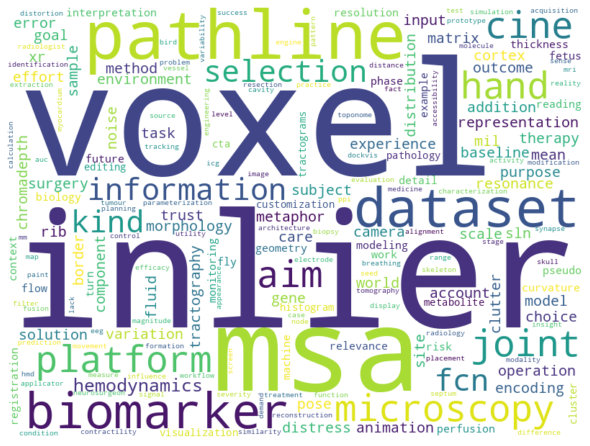

In [145]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = unique_word_set
text = " ".join(text)

wordcloud = WordCloud(width=800, height=600,
                      background_color='white',
                      min_font_size=10,
                      max_words=200).generate(text)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [4]:
#This is for bag of words
import json

In [5]:
def generate_word_embeddings():
    with open('../articles_data/all_articles_with_thumbnail_metadata.json') as f:
        papers = json.load(f)

    # To encode the papers, we must combine the title and the abstracts to a single string
    article_texts = [paper['article_title'] + ' ' + paper['abstract'] for paper in
                     papers]
    article_titles = [paper['article_title'] for paper in papers]
    return article_titles, article_texts

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

article_titles, article_texts = generate_word_embeddings()


vectorizer = CountVectorizer(min_df=5, stop_words='english')
word_doc_matrix = vectorizer.fit_transform(article_texts)


In [6]:
word_doc_matrix

<236x985 sparse matrix of type '<class 'numpy.int64'>'
	with 13560 stored elements in Compressed Sparse Row format>

In [7]:
import plotly.io as pio
import umap.plot
import plotly.express as px

emb = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)
pio.renderers.default = "browser"
fig = px.scatter(emb.embedding_, x=0, y=1, hover_name=article_titles)
fig.show()


ModuleNotFoundError: No module named 'plotly'

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import numpy as np


tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(article_texts)
tfidf_embedding = umap.UMAP(metric='cosine').fit(tfidf_word_doc_matrix)
fig = px.scatter(tfidf_embedding.embedding_, x=0, y=1, hover_name=article_titles)
fig.show()

pairwise dense output:
 [[1.         0.04317284 0.04571376 ... 0.12882546 0.03482807 0.02386857]
 [0.04317284 1.         0.05384503 ... 0.06159637 0.13527898 0.08175961]
 [0.04571376 0.05384503 1.         ... 0.03043027 0.04267147 0.11528548]
 ...
 [0.12882546 0.06159637 0.03043027 ... 1.         0.09031603 0.03811673]
 [0.03482807 0.13527898 0.04267147 ... 0.09031603 1.         0.09079373]
 [0.02386857 0.08175961 0.11528548 ... 0.03811673 0.09079373 1.        ]]



0.073798401663988

In [27]:
result = dict(zip(article_titles, tfidf_embedding.embedding_.tolist()))
with open('../embeddings/low_dim/' + 'tfidf' + '_low_dim.json', 'w') as f:
    json.dump(result, f)
print("wrote to a file")

wrote to a file


In [28]:
result = dict(zip(article_titles, emb.embedding_.tolist()))
with open('../embeddings/low_dim/' + 'bow' + '_low_dim.json', 'w') as f:
    json.dump(result, f)
print("wrote to a file")

wrote to a file


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import numpy as np


tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(article_texts)

A_sparse = sparse.csr_matrix(tfidf_word_doc_matrix)

similarities = cosine_similarity(A_sparse)
print('pairwise dense output:\n {}\n'.format(similarities))

x = [np.mean(i) for i in similarities]
print(np.mean(x))
# AVG COSINE DIST : 0.068


pairwise dense output:
 [[1.         0.04317284 0.04571376 ... 0.12882546 0.03482807 0.02386857]
 [0.04317284 1.         0.05384503 ... 0.06159637 0.13527898 0.08175961]
 [0.04571376 0.05384503 1.         ... 0.03043027 0.04267147 0.11528548]
 ...
 [0.12882546 0.06159637 0.03043027 ... 1.         0.09031603 0.03811673]
 [0.03482807 0.13527898 0.04267147 ... 0.09031603 1.         0.09079373]
 [0.02386857 0.08175961 0.11528548 ... 0.03811673 0.09079373 1.        ]]

[0.073798401663988, 0.0817083425567406, 0.06776388310520783, 0.06243672993217829, 0.06196817225240609, 0.04565042300207362, 0.07373284076360904, 0.08221935322914527, 0.07328999255426218, 0.07328000709383485, 0.06888574803870369, 0.06370846004889946, 0.06727882293332714, 0.0849723809653203, 0.07014856131214456, 0.04817412099610763, 0.0698998588669329, 0.05577079734127887, 0.040342077788369214, 0.06948865764976594, 0.08270105916380835, 0.06563092485724999, 0.08221289687335591, 0.06729765551587275, 0.05955223677868104, 0.0770869